# F1 statistics & simulation

## Introduction

Credit:
The original version of this notebook was created by David Chevrier, Diggers.

More information: https://www.diggers-consulting.com/blog/articles/how-data-science-could-turn-felipe-massa-a-f1-world-champion

## Dataset
Data from https://ergast.com/mrd/db/#csv
F1 data from 1950 to 2019

## 1. Initialization & creation of the activepivot session

In [1]:
import atoti as tt
import numpy as np
import pandas as pd

session = tt.create_session()

Welcome to Atoti 0.4.0.20200512194154!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## 2. Creation of Stores

In [2]:
drivers_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/drivers.csv", encoding="latin-1"
)
drivers_df.rename(columns={"url": "driver_url"}, inplace=True)
drivers_df.rename(columns={"nationality": "driver_nationality"}, inplace=True)

drivers_store = session.read_pandas(
    drivers_df, keys=["driverId"], store_name="F1 drivers"
)

In [3]:
races_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/races.csv", encoding="latin-1"
)
races_df.rename(columns={"url": "race_url"}, inplace=True)
races_df.rename(columns={"name": "race_name"}, inplace=True)

races_store = session.read_pandas(
    races_df, keys=["raceId"], store_name="F1 races", types={"year": tt.types.STRING}
)

In [4]:
constructors_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/constructors.csv", encoding="latin-1"
)
constructors_df.rename(columns={"url": "constructor_url"}, inplace=True)
constructors_df.rename(columns={"name": "constructor_name"}, inplace=True)
constructors_df.rename(columns={"nationality": "constructor_nationality"}, inplace=True)

constructors_store = session.read_pandas(
    constructors_df, keys=["constructorId"], store_name="F1 constructors",
)

In [5]:
resultsTypes = {
    "points": tt.types.DOUBLE,
    "resultId": tt.types.STRING,
}

results_store = session.read_csv(
    "s3://data.atoti.io/notebooks/formula-one/results.csv",
    keys=["resultId"],
    store_name="F1 results",
    types=resultsTypes,
)

The store has been sampled because there is more than 10000 lines in the files to load.Call Session.load_all_data()  to trigger the full load of the data.


In [6]:
results_store.join(drivers_store, mapping={"driverId": "driverId"})
results_store.join(races_store, mapping={"raceId": "raceId"})
results_store.join(constructors_store, mapping={"constructorId": "constructorId"})

## 3. Cube

### Cube for Race results

In [7]:
f1cube = session.create_cube(results_store, "F1Cube")

In [8]:
session.load_all_data()

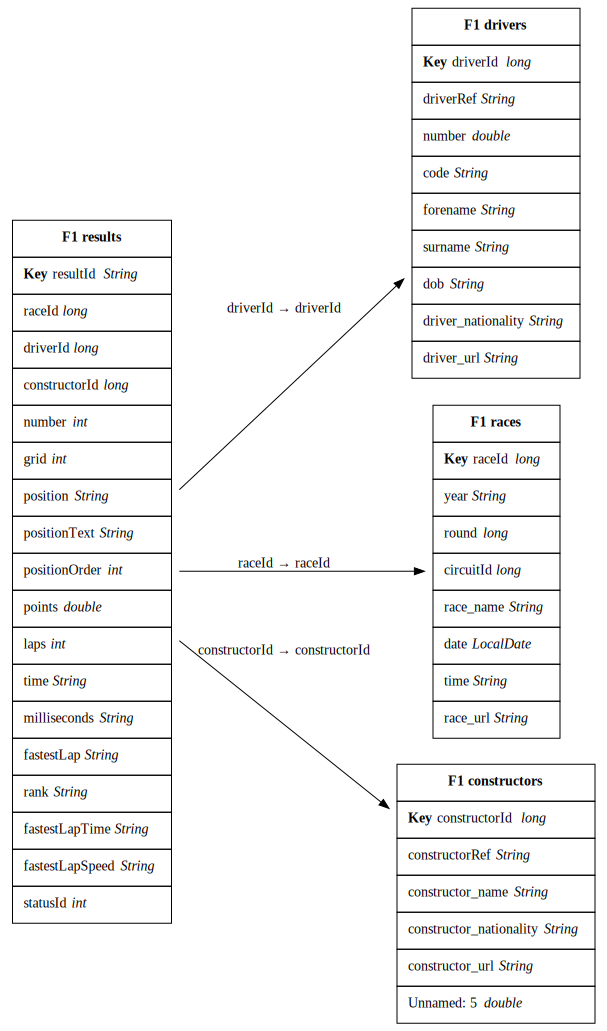

In [9]:
f1cube.schema

In [10]:
lvl = f1cube.levels
m = f1cube.measures
h = f1cube.hierarchies

## 4. First data visualization

In [12]:
f1cube.visualize("Total number of races per driver")

Install and enable the Atoti JupyterLab extension to see this widget.

In [13]:
f1cube.visualize("Total points per drivers")

Install and enable the Atoti JupyterLab extension to see this widget.

In [15]:
f1cube.visualize("Total points per constructors")

Install and enable the Atoti JupyterLab extension to see this widget.

In [17]:
f1cube.visualize("TOP-5 drivers with highest total points in career")

## check here in the widget configuration the "TopCount" filter used to select only the top-5
## check here the cell metadata to sort the data in the chart
#     "plotly": {
#         "layout": {
#             "yaxis": {
#                 "categoryorder": "total ascending"
#             }
#         }
#     },

Install and enable the Atoti JupyterLab extension to see this widget.

### World champion

In [18]:
m["Top driver"] = tt.agg.max_member(m["points.SUM"], lvl["driverRef"])
m["Top constructor"] = tt.agg.max_member(m["points.SUM"], lvl["constructor_name"])

In [20]:
f1cube.visualize("Top driver by year")

Install and enable the Atoti JupyterLab extension to see this widget.

In [22]:
f1cube.visualize("Top driver by race")

Install and enable the Atoti JupyterLab extension to see this widget.

In [24]:
f1cube.visualize("Top constructor by year")

Install and enable the Atoti JupyterLab extension to see this widget.

In [26]:
f1cube.visualize("Top constructor by race")

Install and enable the Atoti JupyterLab extension to see this widget.

## 6. Simulations
Variation of points scoring rule in F1 history  
[EN version](https://en.wikipedia.org/wiki/List_of_Formula_One_World_Championship_points_scoring_systems)  
[FR version](https://fr.wikipedia.org/wiki/Classement_des_pilotes_de_Formule_1_par_nombre_de_points#%C3%89volution_de_l'attribution_des_points_au_cours_du_temps)

### Preparation of a dataframe for the different scoring systems

In [27]:
# index = race year, 1 column for each position, values are the number of points scored for the race position
scoring_columns = np.arange(1, 41)
scoring_index = (
    "sc1950to1959fl sc1960 sc1961to1990 sc1991to2002 sc2003to2009 sc2010to2013 sc2014lr sc2015to2018 sc2019fl"
).split()

In [28]:
# check
dfscoring = pd.DataFrame(0, index=scoring_index, columns=scoring_columns)

In [29]:
# before 1991, the calculation rule is not a simple aggregation given that only the Nth best race results were retained...
# dfscoring.loc['sc1950to1959fl'][1,2,3,4,5] = [8,6,4,3,2] #fastest lap bonus +1 point
# dfscoring.loc['sc1960'][1,2,3,4,5,6] = [8,6,4,3,2,1]
# dfscoring.loc['sc1961to1990'][1,2,3,4,5,6] = [9,6,4,3,2,1]
dfscoring.loc["sc1991to2002"][1, 2, 3, 4, 5, 6] = [10, 6, 4, 3, 2, 1]
dfscoring.loc["sc2003to2009"][1, 2, 3, 4, 5, 6, 7, 8] = [10, 8, 6, 5, 4, 3, 2, 1]
dfscoring.loc["sc2010to2013"][1, 2, 3, 4, 5, 6, 7, 8, 9, 10] = [
    25,
    18,
    15,
    12,
    10,
    8,
    6,
    4,
    2,
    1,
]
# dfscoring.loc['sc2014lr'][1,2,3,4,5,6,7,8,9,10] = [25,18,15,12,10,8,6,4,2,1] #last race bonus double points
dfscoring.loc["sc2015to2018"] = dfscoring.loc["sc2010to2013"]
# dfscoring.loc['sc2019fl'] = dfscoring.loc['sc2010to2013'] #fastest lap bonus +1 point

In [30]:
# check
dfscoring

,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
sc1950to1959fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sc1960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sc1961to1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sc1991to2002,10,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sc2003to2009,10,8,6,5,4,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
sc2010to2013,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0
sc2014lr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sc2015to2018,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0
sc2019fl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Simulation on points

In [31]:
# Creation of simulation
pointssystem_sim = f1cube.setup_simulation(
    "pointssystem_sim",
    levels=[lvl["positionText"], lvl["resultId"]],
    replace=[m["points.SUM"]],
    base_scenario="Base",
)

In [32]:
# Creation of the different scenarios
sc2015to2018_scenario = pointssystem_sim.scenarios["System 2015 to 2018"]
sc1991to2002_scenario = pointssystem_sim.scenarios["System 1991 to 2002"]
sc2003to2009_scenario = pointssystem_sim.scenarios["System 2003 to 2009"]

In [33]:
# Feed of the different scenarios with points from related scoring systems
for i in range(1, 11):
    x = float(dfscoring.loc["sc2015to2018"][i])
    sc2015to2018_scenario += (str(i), "*", x)

    x = float(dfscoring.loc["sc1991to2002"][i])
    sc1991to2002_scenario += (str(i), "*", x)

    x = float(dfscoring.loc["sc2003to2009"][i])
    sc2003to2009_scenario += (str(i), "*", x)

In [34]:
sc2015to2018_scenario.head(10)
# sc1991to2002_scenario.head(10)
# sc2003to2009_scenario.head(10)

,,pointssystem_sim_points.SUM_replace,Priority
positionText,resultId,,
1,*,25.0,0.0
2,*,18.0,0.0
3,*,15.0,0.0
4,*,12.0,0.0
5,*,10.0,0.0
6,*,8.0,0.0
7,*,6.0,0.0
8,*,4.0,0.0
9,*,2.0,0.0


In [36]:
#  Member [Measures].[Top driver (1)] AS [Measures].[Top driver], FORE_COLOR = iif(
#   [Measures].[Top driver] <> (
#     [Measures].[Top driver],
#     [Measure Simulations].[pointssystem_sim].[pointssystem_sim].[Base]
#   ),
#   "red",
#   NULL
# )
f1cube.visualize("Champion comparison")

Install and enable the Atoti JupyterLab extension to see this widget.

## 8. Charts

### Showing the differences for the race result of a famous GP, Brazil 2008
Where we see how the 1991-2002 scoring systems makes a big difference between chamionship rivals Massa & Hamilton
See race summary here :https://www.youtube.com/watch?v=XHSeGou-pCI ;)

In [38]:
f1cube.visualize("Base vs. Simulation - Brazil 2008")

Install and enable the Atoti JupyterLab extension to see this widget.

### Showing the differences for the 2008 world championship result
Would Felipe Massa have become world champ in 2008 with the 1991-2002 scoring system?? YES!

In [40]:
# chart
f1cube.visualize("Base vs. Simulation System 1991 to 2002 - 2008 Championship")

Install and enable the Atoti JupyterLab extension to see this widget.

In [42]:
# 2008 championship standings table
f1cube.visualize("Base vs. Simulation - 2008 Championship table")

Install and enable the Atoti JupyterLab extension to see this widget.